# Tree SHAP

## Definition and intuition

SHAP is the method that unifies many additive feature attribution methods, by giving a strong theoretical background inspired by coalitional game theory.
The true feature attribution is the one one that satisfies two important criteria : 
* Local accuracy: the sum of all feature attributions is the value predicted by the model 
* Consistency: When we change the model such that it relies more on a certain feature then the attributed importance for that feature should not decrease  

With these two properties we can have a theoretical guarantee on the uniqueness of the feature attribution value, the shapely value.  
For trees there is a heuristic method called TreeInterpreter ([see notebook](treeinterpreter.ipynb))  
But is has been shown (Interpretable Machine Learning with XGBoost(https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27)) that this method is inconsistent.  
So tree SHAP comes to adapt this method in order to find the shapely values and respect the two feature attribution properties.
It basically looks at all possible subsets of features and computes the expected value for each subset, and then gives the traditional Shapely value

## Interpretability with tree SHAP

### Characteristics 
* Model-specific: This method is specific to tree based models (decision trees, random forest, XGBoost...) 
* Local: we explain the decision for a single sample  

NB: If we compute mean(|tree_shap|) this gives us global interpretability that is more consistent than gain or split based feature importance.

## Importations
The implementation of SHAP used in this notebook is from the implementation of one of the creators ([see on GitHub](https://github.com/slundberg/shap))

In [1]:
# specific importations to SHAP
import shap

# Importing black box models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report

# import datasets
from mlinutils.datasets import Bikes, Loans

import mlinutils.sanity as san

In [2]:
#  make plot outputs appear and be stored within the notebook
%matplotlib inline

## The datasets we're using 

### Data description
The full description of the Datasets that are used in this entire collection of notebooks is available separately 
* Bike sharing: Daily counts of bike rentals from bike sharing along with weather and seasonal information. <a href="bike_sharing_dataset.ipynb">See bike sharing dataset exploration</a>.
* Lending club: information on users and wether or not they default on their payments from a peer to peer lending online service <a href="lending_club_dataset">see lending club dataset exploration</a> 

### Data importation 

In [3]:
# Importing bike sharing and lending club data set
bikes = Bikes()
bk_X_train, bk_X_test, bk_y_train, bk_y_test = bikes.load()

### Data preview
Take a peak into the data we'll be using !

In [4]:
bikes.preview()

This dataset contains 17379 instances with 14 attributes


,season,year,month,hour,holiday,week_day,working_day,weather_situation,temperature,felt_temperature,humidity,wind_speed,count,days_since_2011
5878,fall,0.0,September,6am-10am,0.0,Wednesday,1.0,Bad,24.60,27.275,88.0,8.9981,66.0,249.0
10992,summer,1.0,April,9pm-5am,0.0,Sunday,0.0,Good,16.40,20.455,40.0,0.0000,7.0,463.0
12633,summer,1.0,June,11am-4pm,0.0,Friday,1.0,Good,29.52,32.575,39.0,12.9980,376.0,531.0
8834,spring,1.0,January,9pm-5am,0.0,Sunday,0.0,Good,10.66,13.635,60.0,7.0015,58.0,372.0
14368,fall,1.0,August,9pm-5am,0.0,Sunday,0.0,Good,26.24,28.790,83.0,8.9981,166.0,603.0


## Application

### Plan
The tree based model that we are going to explain is random forests for both regression (bike sharing) and classification (lending club) task:
* <a href=#reg>Regression with Bike Sharing</a>
    * <a href=#regm> Model creation and sanity checks</a>
    * <a href=#rege> Explanation </a>
* <a href=#clf>Classification with Lending Club</a>
    * <a href=#clfm> Model creation and sanity checks </a>
    * <a href=#clfe> Explanation </a>
* <a href=#conc>Conclusion</a>

### Regression with Bike Sharing <a name=reg>

#### Model creation and sanity checks <a name=regm>

In [5]:
bike_rf = RandomForestRegressor(n_estimators=300, max_depth=12, max_features="sqrt", random_state=22)
bike_rf = bike_rf.fit(bk_X_train, bk_y_train)

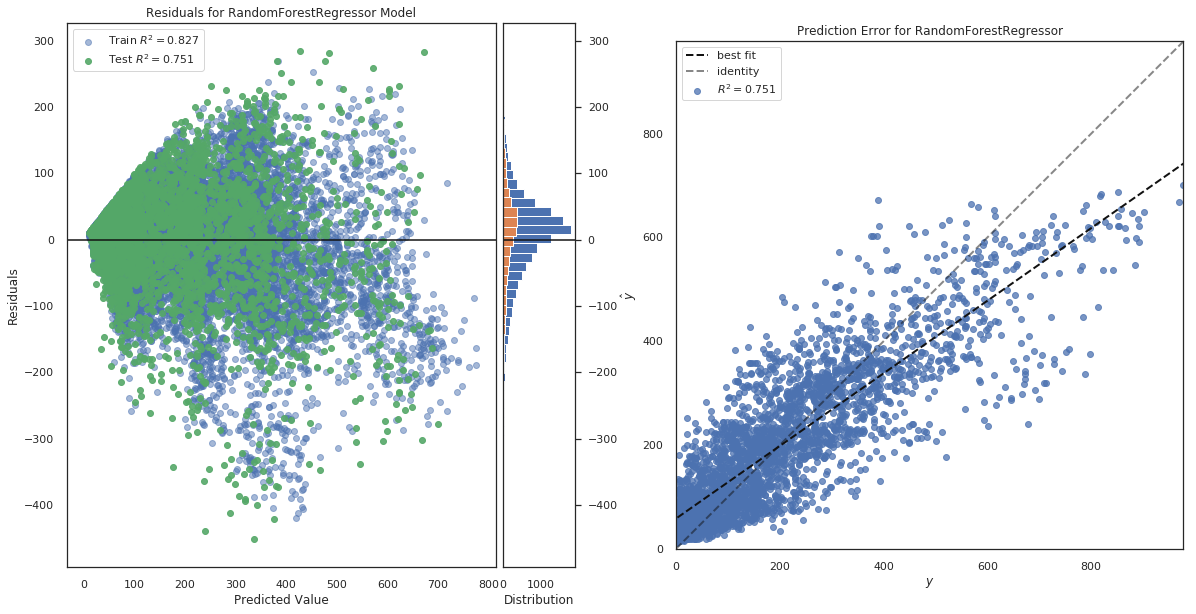

In [6]:
san.regression_sanity_check(bike_rf, bk_X_train, bk_X_test, bk_y_train, bk_y_test)

#### Explanation <a name=rege>

In [7]:
bikes_tree_explainer = shap.TreeExplainer(bike_rf)

In [8]:
sample_bike = bk_X_test.iloc[55]

## recovers the original format just for reading convenience
bikes.data.iloc[[sample_bike.name],:]

,season,year,month,hour,holiday,week_day,working_day,weather_situation,temperature,felt_temperature,humidity,wind_speed,count,days_since_2011
16133,winter,1.0,November,9pm-5am,0.0,Friday,1.0,Good,13.12,16.665,81.0,6.0032,162.0,678.0


In [9]:
sample_bike_shap_values = bikes_tree_explainer.shap_values(sample_bike)

In [10]:
shap.initjs()
shap.force_plot(bikes_tree_explainer.expected_value, sample_bike_shap_values, sample_bike, feature_names=bk_X_train.columns)

In [11]:
print("Random forest prediction is:", bike_rf.predict(sample_bike.values.reshape(1, -1)))

Random forest prediction is: [69.4723101]


> Explanations here resemble results we got for kernel shap and LIME meaning the upward trend in bike sharing and th epositive impact of good weather ...

### Classification with lending club <a name=clf>

In [12]:
# Importing lending club data set
loans = Loans()
ln_X_train, ln_X_test, ln_y_train, ln_y_test = loans.load()

In [13]:
loans.preview()

This dataset contains 98339 instances with 19 attributes


,loan_amnt,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,open_acc_6m,inq_fi,mths_since_crl_was_opened,bad_loan_status
58873,7200.0,13.11,242.98,6.0,5.0,MORTGAGE,50000.0,Source Verified,debt_consolidation,15.13,0.0,1.0,18.0,23055.0,44.5,1.0,1.0,87.032588,0
24049,7800.0,17.57,280.31,4.0,10.0,MORTGAGE,85000.0,Not Verified,debt_consolidation,11.83,0.0,2.0,14.0,8192.0,24.9,1.0,1.0,139.041869,0
12473,8500.0,13.35,287.84,5.0,2.0,RENT,43000.0,Source Verified,debt_consolidation,14.57,0.0,1.0,8.0,8274.0,57.9,1.0,1.0,74.941991,1
70457,15250.0,21.98,421.02,3.0,5.0,MORTGAGE,80000.0,Verified,small_business,9.27,0.0,3.0,11.0,7999.0,28.1,1.0,1.0,229.031397,0
97590,15000.0,13.43,508.53,5.0,4.0,RENT,57000.0,Verified,debt_consolidation,17.16,0.0,2.0,11.0,10530.0,45.0,1.0,1.0,114.959239,0


#### Model creation and sanity checks <a name=clfm>

In [14]:
# Model creation 
loan_rf =  RandomForestClassifier(n_estimators=100, max_depth=12, max_features="sqrt", random_state=22) 
loan_rf = loan_rf.fit(ln_X_train, ln_y_train)

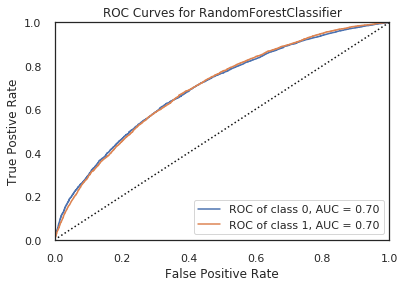

In [15]:
san.classification_sanity_check(loan_rf, ln_X_train, ln_X_test, ln_y_train, ln_y_test)

### Explanation <a name=clfe>

In [16]:
loans_tree_explainer = shap.TreeExplainer(loan_rf)

In [17]:
sample_loans = ln_X_test.iloc[3]

## recovers the original format just for reading convenience
loans.data.iloc[[sample_loans.name], :]

,loan_amnt,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,open_acc_6m,inq_fi,mths_since_crl_was_opened,bad_loan_status
41230,7000.0,15.61,244.76,4.0,1.0,RENT,56550.0,Source Verified,debt_consolidation,23.6,1.0,1.0,10.0,2193.0,17.8,1.0,1.0,53.980575,1


In [18]:
sample_loans_shap_values = loans_tree_explainer.shap_values(sample_loans)

In [19]:
shap.force_plot(loans_tree_explainer.expected_value[1], sample_loans_shap_values[1], sample_loans, feature_names=ln_X_train.columns)

In [20]:
print("Random forest prediction for 'Bad loan' class is:", loan_rf.predict_proba(sample_loans.values.reshape(1, -1))[0][1])

Random forest prediction for 'Bad loan' class is: 0.3018655568925749


> Results are coherent with data exploration and other methods

#### Conclusion <a name=conc>

Tree SHAP considers all scenarios where we drop a subset of features and watch the expected value change. This method guarantees both local accuracy and consistency without sacrificing computational time.